# Non linear LSTM

In [1]:
import tensorflow as tf

from tensorflow.keras.layers import Input, SimpleRNN, GRU, LSTM, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
tf.__version__

'2.1.0'

In [3]:
tf.test.gpu_device_name()

'/device:GPU:0'

We will generate a time series of the form: $$x(t) = \sin(\omega t^2).$$ Meaning that the frequency and the period of the time wave changes over time.

In [5]:
series = np.sin((0.1 * np.arange(400)) * (0.1 * np.arange(400)))

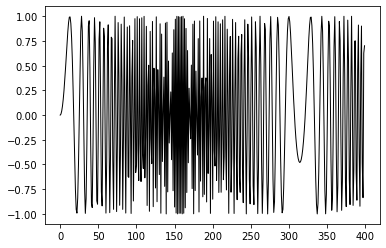

In [15]:
plt.plot(series, c='k', lw=1)
plt.show()

In [7]:
T: int = 10
D: int = 1
X_store: list = []
Y_store: list = []

for t in range(len(series) - T):
    x = series[t:t+T]
    X_store.append(x)
    y = series[t+T]
    Y_store.append(y)

X = np.array(X_store).reshape(-1, T)
Y = np.array(Y_store)
N: int = len(X)
print(f"X.shape: {X.shape}, Y.shape: {Y.shape}")

X.shape: (390, 10), Y.shape: (390,)


Next, we are going to build an autoregressive linear model using TensorFlow's Functional API:

In [9]:
inputs = Input(shape=(T,))
x = Dense(1)(inputs)
model = Model(inputs, x)
model.compile(loss='mse', optimizer=Adam(learning_rate=0.01))

We can train the RNN:

In [10]:
r = model.fit(X[:-N//2], Y[:-N//2], epochs=80, validation_data=(X[-N//2:], Y[-N//2:]))

Train on 195 samples, validate on 195 samples
Epoch 1/80
195/195 [==============================] - 1s 7ms/sample - loss: 1.6690 - val_loss: 1.4228
Epoch 2/80
195/195 [==============================] - 0s 174us/sample - loss: 1.4298 - val_loss: 1.2494
Epoch 3/80
195/195 [==============================] - 0s 169us/sample - loss: 1.2488 - val_loss: 1.1204
Epoch 4/80
195/195 [==============================] - 0s 174us/sample - loss: 1.0901 - val_loss: 1.0128
Epoch 5/80
195/195 [==============================] - 0s 169us/sample - loss: 0.9609 - val_loss: 0.9139
Epoch 6/80
195/195 [==============================] - 0s 189us/sample - loss: 0.8560 - val_loss: 0.8337
Epoch 7/80
195/195 [==============================] - 0s 189us/sample - loss: 0.7772 - val_loss: 0.7707
Epoch 8/80
195/195 [==============================] - 0s 168us/sample - loss: 0.7078 - val_loss: 0.7196
Epoch 9/80
195/195 [==============================] - 0s 184us/sample - loss: 0.6529 - val_loss: 0.6867
Epoch 10/80
195/195 

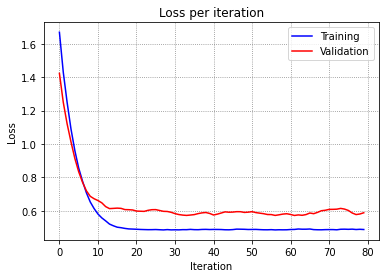

In [14]:
plt.plot(r.history['loss'], label='Training', c='b')
plt.plot(r.history['val_loss'], label='Validation', c='r')
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.title('Loss per iteration')
plt.grid(c='gray', ls=':')
plt.legend()
plt.show()

The loss per iteration is still high as fluctuating around 0.6 for the validation set. This is much higher that what we had before in the [Autoregressive Models with TensorFlow 2.3.1](https://github.com/kbantoec/deep_learning/blob/master/tf2/autoregressive_model.ipynb) notebook.